### Environment Setup


In [0]:
from __future__ import absolute_import, division, print_function
import os
import numpy as np
import matplotlib.pyplot as plt

In [0]:
!pip install -q tensorflow-gpu==2.0.0-rc0
import tensorflow as tf

In [3]:
keras = tf.keras
imdb = keras.datasets.imdb
print(tf.__version__)

2.0.0-rc0


### Load IMDB movie review dataset

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(
    path='imdb.npz',
    num_words=None,
    skip_top=0,
    maxlen=None,
    seed=113,
    start_char=1,
    oov_char=2,
    index_from=3
)

### Load IMDB word index

In [5]:
word_index = tf.keras.datasets.imdb.get_word_index(path='imdb_word_index.json')

1646592/1641221 [==============================] - 0s 0us/step


In [0]:
import numpy as np
unique, counts = np.unique(y_train, return_counts=True)

### Check comment count

In [7]:
 print(np.asarray((unique, counts)).T)

[[    0 12500]
 [    1 12500]]


In [0]:
idx = np.argwhere(y_train>0) # Select positive comment's index in training data
np.random.shuffle(idx) #Shuffle it at random

Lets randomly select a fraction of the positive reviews while keeping all negative reviews. We are going to use these subset of positive reviews as our positive base, and oversample these reviews in the base at random.

In [0]:
FRAC = 0.1
idxs = idx[:round(len(idx)*FRAC)] # Select random fraction FRAC
y_trains = y_train[idxs]
x_trains = x_train[idxs]

# preserve negative cases
idxn = np.argwhere(y_train==0)
x_train0 = x_train[idxn]
y_train0 = y_train[idxn]

In [0]:
# this is for the subsampling training. 
x_train_new = np.concatenate((x_train0, x_trains), axis=None)
y_train_new = np.concatenate((y_train0, y_trains), axis=None)

In [20]:
x_trains.shape # this is the small samples for positive case.

(1250, 1)

### Oversampling
Lets oversample the positive comments up do ten times the original positive comment count. This ensures the counts of positive and negative reviews are same. This also constitutes our training dataset for this milestone. 

In [0]:
x_trains_os = np.tile(x_trains, (10,1)) # oversampling up to 10x
y_trains_os = np.tile(y_trains, (10,1))

In [23]:
print(x_train0.shape, x_trains_os.shape)

(12500, 1) (12500, 1)


In [0]:
x_train_assembled = np.concatenate((x_train0, x_trains_os), axis = None)
y_train_assembled = np.concatenate((y_train0, y_trains_os), axis = None)

Now lets check tranining dataset size.

In [25]:
print(x_train_assembled.shape)

(25000,)


Lets also append IMDB word index with extra tokens for handling sentence length and demarcations. 

In [0]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

Lets pad each sentence to maximimum length of 256 words. We may take advantage of `pad_sequences` function provided to speed simplify our task. We will pad sentences with `<PAD>` token up to 256 words. 

In [0]:
train_data = tf.keras.preprocessing.sequence.pad_sequences(x_train_assembled,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

### Model Architecture
Lets build a simple text classification model. Start with embedding layer that convert a word into multi-dimensional vector representation. Then we feed that representation to a bidirectional Long-Short Terms Memory cell (LSTM) that uses 128 (a hyperparameter - arbitrarily chosen, feel free to experiment) dimensions to represent text sequence, follow by a dense layer to aggregate the LSTM output before making a classification. 

In [34]:
# input shape is the vocabulary count used for the movie reviews (10,000 words)
vocab_size = len(word_index)

MAX_SENTENCE_LENGTH=256
EMBEDDING_SIZE=16
HIDDEN_LAYER_SIZE=64
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          5669632   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               197632    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 5,883,777
Trainable params: 5,883,777
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

### Cross Validation
It is a good practice to set up a portion of training data for cross validation at the end of each training epoch. This helps us identify proper training epochs and prevent overfitting by memorizing training data.

In [0]:
# Shuffle training data for cross validation during training cycle
FRAC = 0.8 # fraction of training data used for training. Remaining is for cross validation.
idx = np.arange(len(train_data))
np.random.shuffle(idx)

idxs = idx[:round(len(idx)*FRAC)] # Select random 80% for training data
partial_x_train = train_data[idxs]
partial_y_train = y_train_assembled[idxs]

x_val = np.delete(train_data, idxs.tolist(), axis=0) # select remaining as cross validation data
y_val = np.delete(y_train_assembled, idxs.tolist(), axis=0)


In [37]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 20000 samples, validate on 5000 samples
Epoch 1/40
20000/20000 [==============================] - 15s 755us/sample - loss: 0.6607 - acc: 0.6524 - val_loss: 0.5562 - val_acc: 0.7428
Epoch 2/40
20000/20000 [==============================] - 7s 327us/sample - loss: 0.4677 - acc: 0.8551 - val_loss: 0.2078 - val_acc: 0.9186
Epoch 3/40
20000/20000 [==============================] - 7s 329us/sample - loss: 0.0772 - acc: 0.9760 - val_loss: 0.0522 - val_acc: 0.9844
Epoch 4/40
20000/20000 [==============================] - 7s 328us/sample - loss: 0.0091 - acc: 0.9977 - val_loss: 0.0429 - val_acc: 0.9886
Epoch 5/40
20000/20000 [==============================] - 7s 326us/sample - loss: 0.0023 - acc: 0.9997 - val_loss: 0.0437 - val_acc: 0.9886
Epoch 6/40
20000/20000 [==============================] - 7s 330us/sample - loss: 0.0011 - acc: 0.9999 - val_loss: 0.0329 - val_acc: 0.9926
Epoch 7/40
20000/20000 [==============================] - 7s 327us/sample - loss: 5.3409e-04 - acc: 0.9999 - v

In [38]:
results = model.evaluate(test_data, y_test)

25000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [39]:
print(model.metrics_names)

['loss', 'acc']


In [40]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

Lets take a look at training process to make sure the model is improving through training epochs.

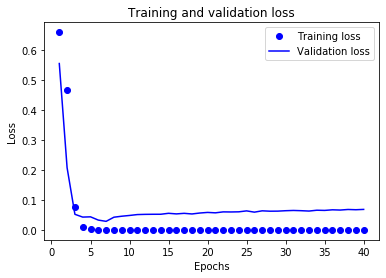

In [41]:
import matplotlib.pyplot as plt

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

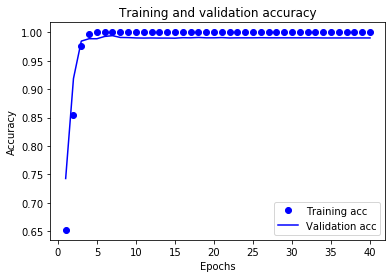

In [42]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [0]:
predicted = model.predict(test_data)

### Prediction on test dataset
Lets create a confusion matrix to see how the model perform with respect to each review type.

In [0]:
predicted[predicted > 0.5] = 1
predicted[predicted <= 0.5] = 0
predictedf = predicted.flatten().astype(int)

import pandas as pd
df3 = pd.DataFrame(data=predictedf, columns=['predicted'])
refdf = pd.DataFrame(data=y_test, columns=['actual'])

y_actu = pd.Series(refdf['actual'], name='ACTUAL')
y_pred = pd.Series(df3['predicted'], name='PREDICTED')
predicted_results = y_pred.tolist()
truth = y_actu.tolist()

dl_confusion = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

In [45]:
dl_confusion

Predicted,0,1,All
Actual,,,
0,12210,290,12500
1,7934,4566,12500
All,20144,4856,25000


Lets take a closer look at model performance for each type of review.

In [46]:
from sklearn.metrics import classification_report
report = classification_report(truth, predicted_results)
print(report)

              precision    recall  f1-score   support

           0       0.61      0.98      0.75     12500
           1       0.94      0.37      0.53     12500

    accuracy                           0.67     25000
   macro avg       0.77      0.67      0.64     25000
weighted avg       0.77      0.67      0.64     25000



The outcome of oversampling positive reviews is a trade-off and compromise of precision and recall between different types of reviews. The degradation in recall (performance with respect to false negative) for positive comment indicates that the model mistakens many positive comments as negative comments.